              precision    recall  f1-score   support

       False       0.99      0.98      0.98       150
        True       0.73      0.80      0.76        10

    accuracy                           0.97       160
   macro avg       0.86      0.89      0.87       160
weighted avg       0.97      0.97      0.97       160

[[147   3]
 [  2   8]]


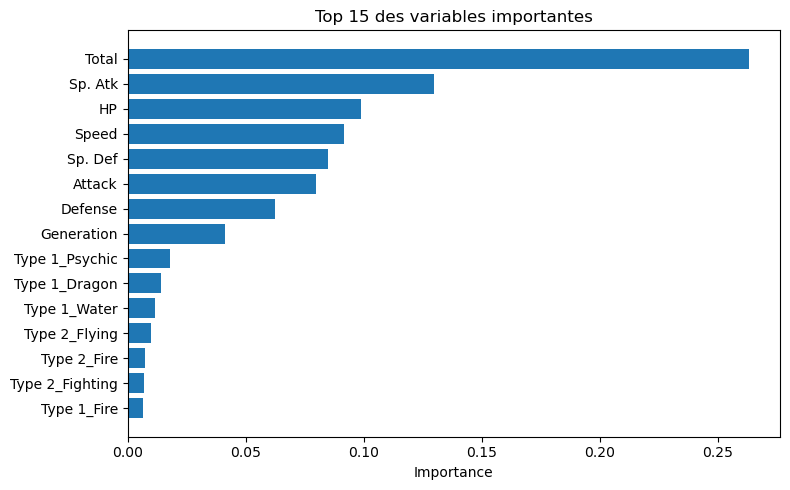

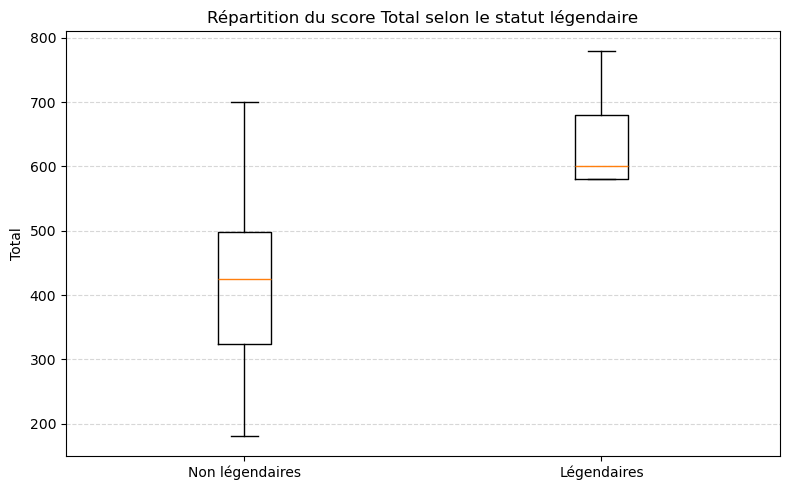

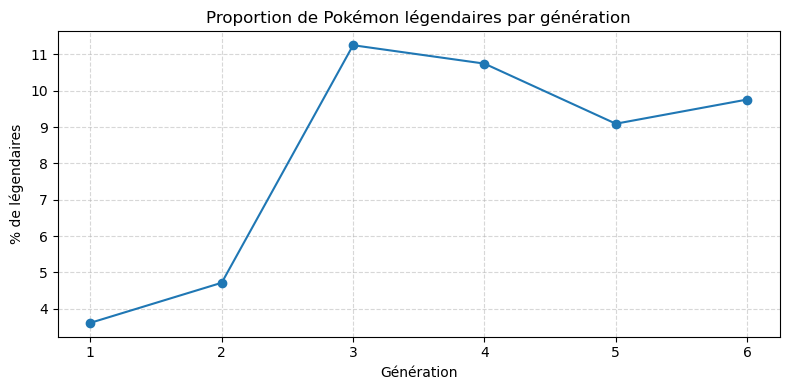

PCA: 25 composantes retenues (95% var).


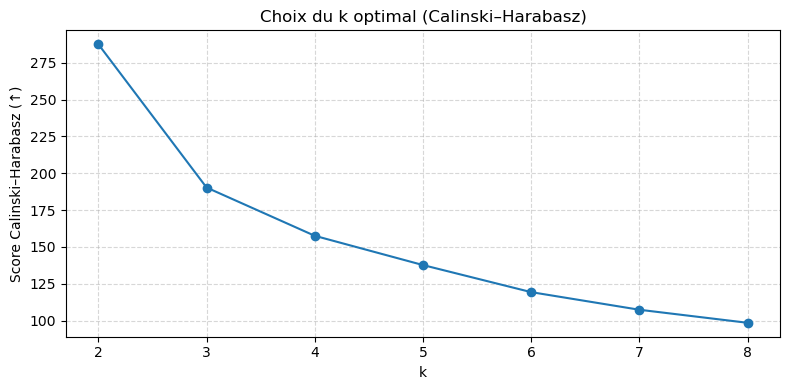

→ k optimal (Calinski–Harabasz) : 2 | score=287.48


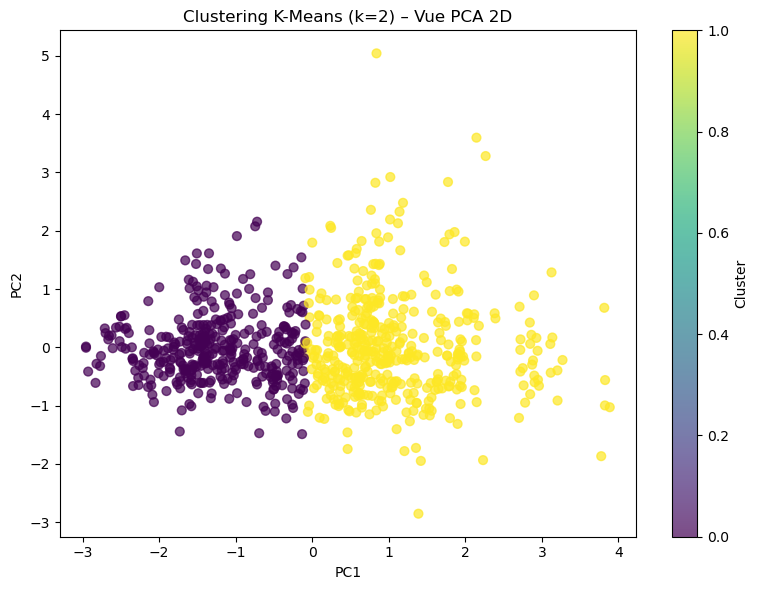


=== Profils par cluster (moyennes) ===
          Total     HP  Attack  Defense  Sp. Atk  Sp. Def  Speed
Cluster                                                         
0        327.82  52.93   58.16    55.83    52.71    53.22  54.98
1        527.88  83.38   97.03    89.42    90.21    88.06  79.78

=== % de Pokémon légendaires par cluster ===
Cluster
0     0.00
1    15.15
Name: Legendary, dtype: float64


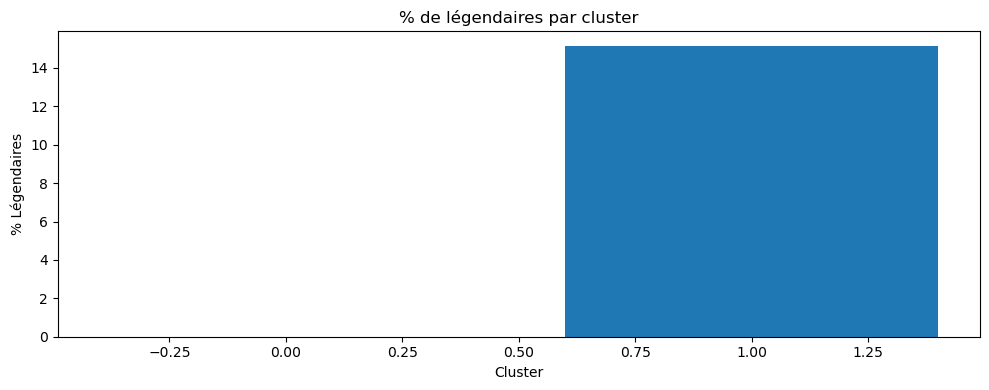

In [15]:
# Projet Pokémon Machine Learning (version Calinski–Harabasz uniquement)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

# =========================
# 1) Chargement & préparation (supervisé)
# =========================
df = pd.read_csv("Pokemon.csv")
df = df.drop(columns=['Name', '#'], errors='ignore')

# Encodage des types
df = pd.get_dummies(df, columns=['Type 1', 'Type 2'], drop_first=True)

# Séparation des variables
X = df.drop('Legendary', axis=1)
y = df['Legendary']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================
# 2) Modèle supervisé
# =========================
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# =========================
# 3) Visualisations supervisées
# =========================
# (a) Variables les plus importantes
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(8, 5))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), X.columns[indices])
plt.xlabel('Importance')
plt.title('Top 15 des variables importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# (b) Boxplot du score Total selon légendaire / pas légendaire
non_leg = df[df['Legendary'] == False]['Total']
leg = df[df['Legendary'] == True]['Total']

plt.figure(figsize=(8, 5))
plt.boxplot([non_leg, leg], tick_labels=['Non légendaires', 'Légendaires'])
plt.ylabel("Total")
plt.title("Répartition du score Total selon le statut légendaire")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# (c) % de légendaires par génération
if 'Generation' in df.columns:
    stats_gen = df.groupby('Generation')['Legendary'].mean() * 100
    plt.figure(figsize=(8, 4))
    plt.plot(stats_gen.index, stats_gen.values, marker='o')
    plt.xlabel("Génération")
    plt.ylabel("% de légendaires")
    plt.title("Proportion de Pokémon légendaires par génération")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# =========================
# 4) Clustering non supervisé (sélection de k par Calinski–Harabasz)
# =========================

# Repart de données propres pour le clustering
df_imp = pd.read_csv("Pokemon.csv").drop(columns=['Name', '#'], errors='ignore')
df_imp_enc = pd.get_dummies(df_imp, columns=['Type 1', 'Type 2'], drop_first=True)

# Retirer la cible 'Legendary' des features (clustering non supervisé)
X_feats = df_imp_enc.drop('Legendary', axis=1) if 'Legendary' in df_imp_enc.columns else df_imp_enc.copy()

# (1) Prétraitement robuste + PCA
scaler = RobustScaler()                      # plus robuste aux outliers que StandardScaler
X_scaled = scaler.fit_transform(X_feats)

# PCA pour compacter le bruit et stabiliser K-Means
pca = PCA(n_components=0.95, random_state=42)  # conserve 95% de variance
X_pca = pca.fit_transform(X_scaled)
print(f"PCA: {X_pca.shape[1]} composantes retenues (95% var).")

# (2) Recherche du meilleur k via Calinski–Harabasz
k_range = range(2, 9)
cali = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=15)
    labels = km.fit_predict(X_pca)
    # Calinski–Harabasz (plus grand = meilleur)
    cali.append(calinski_harabasz_score(X_pca, labels))

# Visualisation de Calinski–Harabasz
plt.figure(figsize=(8, 4))
plt.plot(list(k_range), cali, marker='o')
plt.xlabel("k")
plt.ylabel("Score Calinski–Harabasz (↑)")
plt.title("Choix du k optimal (Calinski–Harabasz)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# (3) Choix auto du k (max Calinski–Harabasz)
best_k = list(k_range)[int(np.argmax(cali))]
print(f"→ k optimal (Calinski–Harabasz) : {best_k} | score={max(cali):.2f}")

# (4) Fit final et affectation
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels_final = kmeans_final.fit_predict(X_pca)

# Ajout du cluster aux données d’origine (pour analyses lisibles)
df_imp['Cluster'] = labels_final

# (5) Visualisation PCA 2D (optionnelle, pour lecture)
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_scaled)  # on repart du scaled pour la vue 2D
plt.figure(figsize=(8, 6))
sc = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df_imp['Cluster'], s=40, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Clustering K-Means (k={best_k}) – Vue PCA 2D")
cbar = plt.colorbar(sc); cbar.set_label("Cluster")
plt.tight_layout()
plt.show()

# (6) Profiling des clusters
stats_cols = [c for c in ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed'] if c in df_imp.columns]

print("\n=== Profils par cluster (moyennes) ===")
print(df_imp.groupby('Cluster')[stats_cols].mean().round(2))

if 'Legendary' in df_imp.columns:
    legendary_ratio = (df_imp.groupby('Cluster')['Legendary'].mean() * 100).round(2)
    print("\n=== % de Pokémon légendaires par cluster ===")
    print(legendary_ratio)
    plt.figure(figsize=(10, 4))
    plt.bar(legendary_ratio.index, legendary_ratio.values)
    plt.xlabel("Cluster")
    plt.ylabel("% Légendaires")
    plt.title("% de légendaires par cluster")
    plt.tight_layout()
    plt.show()
